# Rutford icequake example

Example for one icequake from Rutford Ice Stream, Antarctica.


In [1]:
# Import neccessary modules:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import obspy
import SeisSeeker

%matplotlib notebook
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [4, 3]

## 1. Specify key parameters

In [2]:
# Specify key parameters:
win_len_s = 0.2 # Window to process within. Should be slowest time it might take for a ray to propagate through the entrie array
win_step_inc_s = 0.01 # The step length between windows (overlap between windows is given by win_len_s - win_step_inc_s)
# (Note: There is a trade-off in width of power peaks, with width ~ win_len_s)
norm_all_freqs = False # If True, normalises all frequencies (equivilent to spectral whitening)
remove_autocorr = True

# Specify array to use:
# (receiver coordinates)
stations_fname = os.path.join("inputs", "AS_stations.txt")
stations_df = pd.read_csv(stations_fname)


In [3]:
# Specify date and time to search over:
starttime = obspy.UTCDateTime("2020-01-01T01:30:46.000000Z") 
endtime = starttime + 5

## 2. Get a rough idea of array sensitivity:

In [4]:
# And find min and max distance (and hence frequency) for the array:
vel_assumed = 1.9 #3.8 #3.0
inter_station_dists = []
# Loop over first set of stations:
for index, row in stations_df.iterrows():
    lon1 = row['Longitude']
    lat1 = row['Latitude']
    # Loop over stations again:
    for index, row in stations_df.iterrows():
        lon2 = row['Longitude']
        lat2 = row['Latitude']
        # Calc. inter-station distance:
        r, a, b = obspy.geodetics.base.gps2dist_azimuth(lat1, lon1, lat2, lon2)
        inter_station_dists.append(np.abs(r) / 1000)
inter_station_dists = np.array(inter_station_dists)
inter_station_dists = inter_station_dists[inter_station_dists != 0]


print("Min. inter-station distance:", np.min(inter_station_dists), "km")
print("Therefore, optimal sensitive higher freq.:", vel_assumed / np.min(inter_station_dists), "Hz")
print("Max. inter-station distance:", np.max(inter_station_dists), "km")
print("Therefore, optimal sensitive lower freq.:", vel_assumed / np.max(inter_station_dists), "Hz")

    
    

Min. inter-station distance: 0.019329478028457248 km
Therefore, optimal sensitive higher freq.: 98.29546339548236 Hz
Max. inter-station distance: 0.09234631973482979 km
Therefore, optimal sensitive lower freq.: 20.574723556453616 Hz


## 3. Perform beamforming:

In [6]:
# Setup detection object:
archivedir = "inputs/mseed_data_archive"
outdir = "outputs"
stations_fname = stations_fname
starttime = starttime
endtime = endtime
channels_to_use = ["??Z", "??1", "??2"]
detect_obj = SeisSeeker.processing.setup_detection(archivedir, outdir, stations_fname, starttime, endtime, channels_to_use=channels_to_use)
# Specify array processing parameters:
detect_obj.freqmin = 10
detect_obj.freqmax = 150
detect_obj.num_freqs = 20  # Set small for initial detection and larger for fine detail calculation...
detect_obj.max_sl = 1.0
detect_obj.win_len_s = win_len_s  #1 # Window to process within. Should be slowest time it might take for a ray to propagate through the entrie array
detect_obj.win_step_inc_s = win_step_inc_s # The step length between windows (overlap between windows is given by win_len_s - win_step_inc_s)
detect_obj.remove_autocorr = True
# detect_obj.nproc = 8 #1 # If not specified, will use all available processors.



In [15]:
# Run beamforming:
detect_obj.run_array_proc()


Processing data for year 2020, day 001, channel ??Z
Processing for hour 00
Processing for hour 01
Processing for hour 02
Processing for hour 03
Processing for hour 04
Processing for hour 05
Processing for hour 06
Processing for hour 07
Processing for hour 08
Processing for hour 09
Processing for hour 10
Processing for hour 11
Processing for hour 12
Processing for hour 13
Processing for hour 14
Processing for hour 15
Processing for hour 16
Processing for hour 17
Processing for hour 18
Processing for hour 19
Processing for hour 20
Processing for hour 21
Processing for hour 22
Processing for hour 23
Processing data for year 2020, day 001, channel ??1
Processing for hour 00
Processing for hour 01
Processing for hour 02
Processing for hour 03
Processing for hour 04
Processing for hour 05
Processing for hour 06
Processing for hour 07
Processing for hour 08
Processing for hour 09
Processing for hour 10
Processing for hour 11
Processing for hour 12
Processing for hour 13
Processing for hour 14

<IPython.core.display.Javascript object>


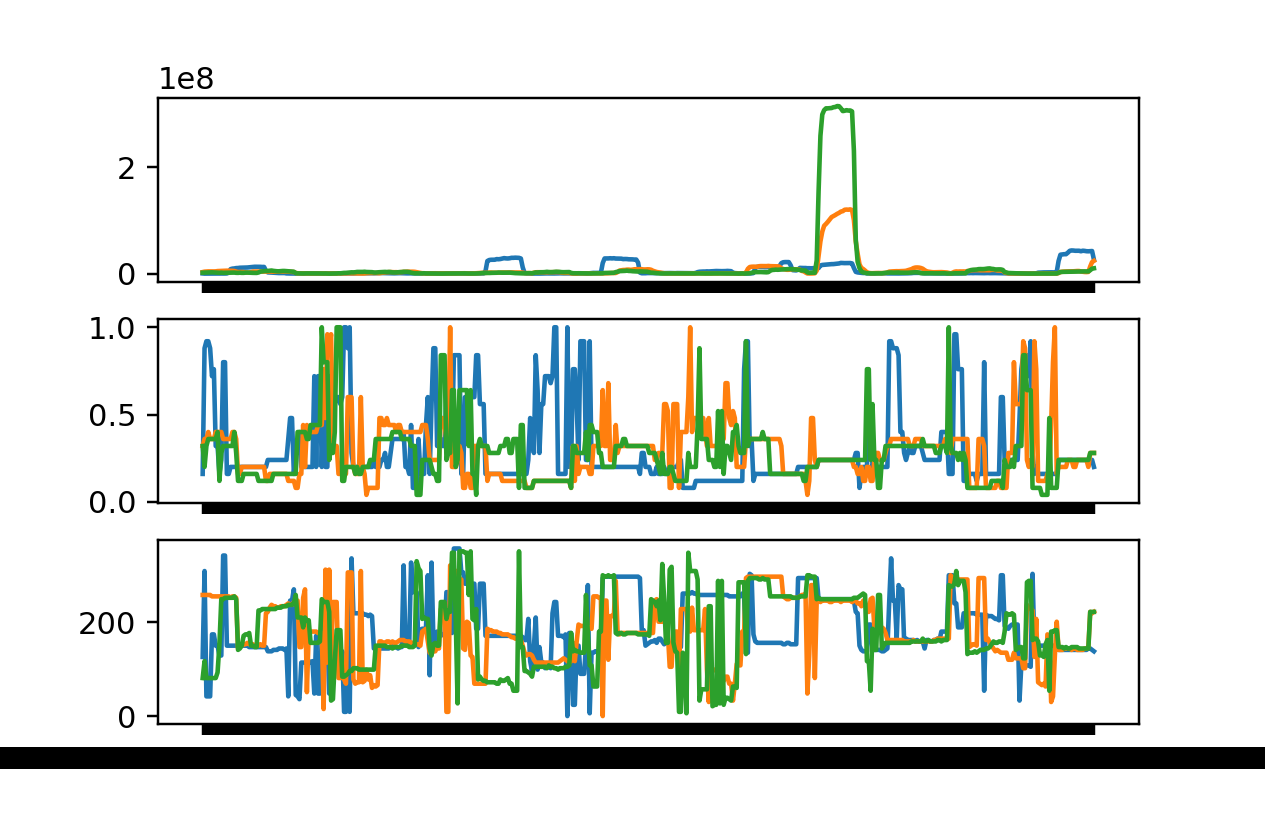

In [17]:
# Plot up beamforming time-series:
t_series_df_Z = pd.read_csv(os.path.join(outdir, "detection_t_series_2020001_0100_chZ.csv"))
t_series_df_N = pd.read_csv(os.path.join(outdir, "detection_t_series_2020001_0100_ch1.csv"))
t_series_df_E = pd.read_csv(os.path.join(outdir, "detection_t_series_2020001_0100_ch2.csv"))
fig, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(t_series_df_Z['t'], t_series_df_Z['power'])
ax[0].plot(t_series_df_Z['t'], t_series_df_N['power'])
ax[0].plot(t_series_df_Z['t'], t_series_df_E['power'])
ax[1].plot(t_series_df_Z['t'], t_series_df_Z['slowness'])
ax[1].plot(t_series_df_Z['t'], t_series_df_N['slowness'])
ax[1].plot(t_series_df_Z['t'], t_series_df_E['slowness'])
ax[2].plot(t_series_df_Z['t'], t_series_df_Z['back_azi'])
ax[2].plot(t_series_df_Z['t'], t_series_df_N['back_azi'])
ax[2].plot(t_series_df_Z['t'], t_series_df_E['back_azi'])
plt.show()

## 4. Detect events within beamforming data:

Note: <mad_window_length_s> not yet implemented.
(Weighted horizontal slowness and back-azi using power)
Pre-processing time-series
Performing phase association
0 / 7
Writing events
Event phase associations:
   bazi1       bazi2          pow1          pow2  slow1     slow2  \
1  171.0  159.000000  3.045238e+07  1.245514e+07   0.16  0.352379   
2  258.0  248.199685  5.618505e+06  3.346068e+08   0.12  0.240000   

                            t1                           t2  
1  2020-01-01T01:30:47.685000Z  2020-01-01T01:30:49.845000Z  
2  2020-01-01T01:30:48.825000Z  2020-01-01T01:30:49.425000Z  


<IPython.core.display.Javascript object>


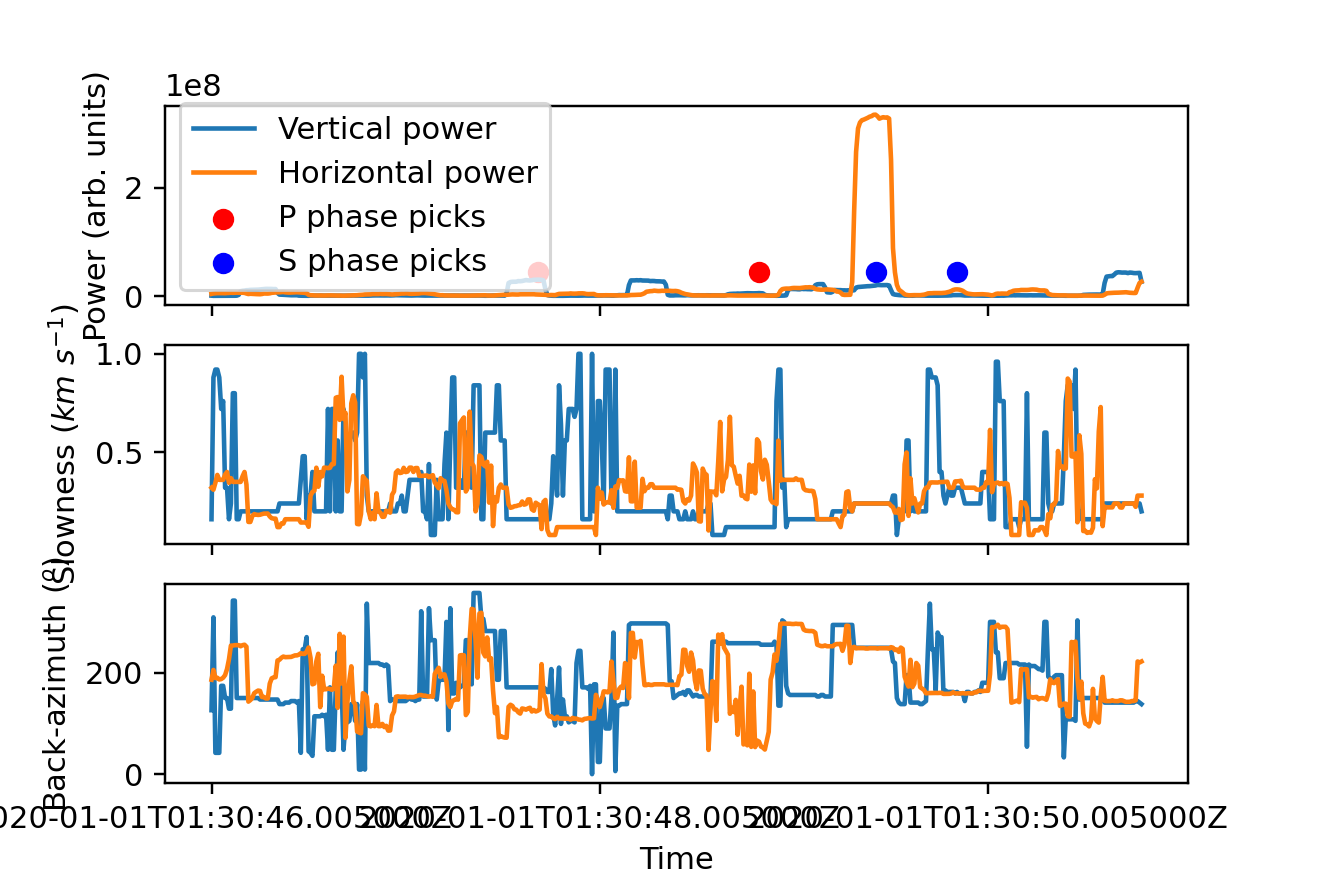

In [18]:
# Specify event detection parameters:
detect_obj.mad_window_length_s = 3600
detect_obj.mad_multiplier = 2 #4 #15 #8
detect_obj.min_event_sep_s = 0.25 #0.2 #0.2
detect_obj.bazi_tol = 15 #10 #10 #45 #10.
detect_obj.max_phase_sep_s = 4.0 #2.5
detect_obj.filt_phase_assoc_by_max_power = True

events_df = detect_obj.detect_events(verbosity=2)

## 5. Locate detected events:

In [20]:

# Create/load lookup tables:
create_LUTs = False #True #False
if create_LUTs:
    # Specify velocity model:
    oneD_vel_model_z_df = pd.read_csv("inputs/1D_vel_model_beamish_refrac.csv")
    # Specify LUT parameters:
    extent_x_m = 4000 #2000
    dxz = [10, 10]
    # And create LUT:
    LUTs_dict = detect_obj.create_location_LUTs(oneD_vel_model_z_df, extent_x_m=extent_x_m, dxz=dxz)

else:
    LUTs_fname = "inputs/LUT/LUTs.pkl"
    LUTs_dict = detect_obj.load_location_LUTs(LUTs_fname)
        

Locating event 1 / 2


<IPython.core.display.Javascript object>


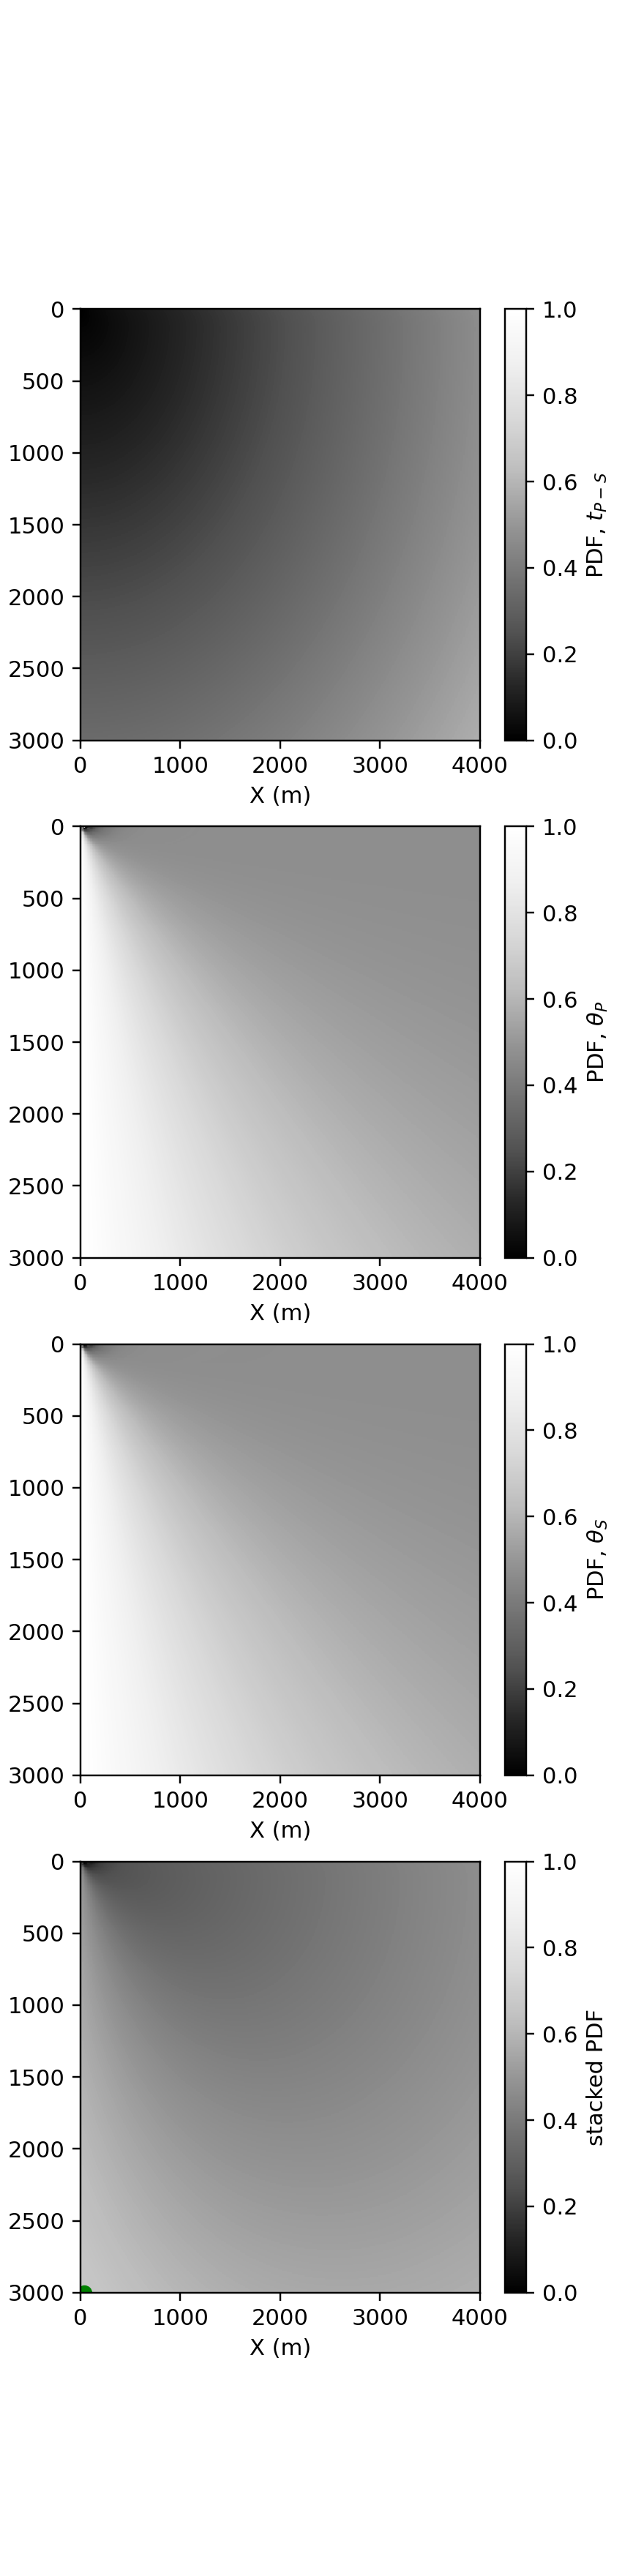

Locating event 2 / 2


/Users/eart0504/Documents/python/github_repositories/SeisSeeker/SeisSeeker/processing/location.py:99: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0].pcolormesh(X, Z, tp_ts_res_pdf, cmap="Greys_r", vmin=0, vmax=1)
/Users/eart0504/Documents/python/github_repositories/SeisSeeker/SeisSeeker/processing/location.py:106: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = axes[1].pcolormesh(X, Z, P_inc_angle_res_pdf, cmap="Greys_r", vmin=0, vmax=1)
/Use

<IPython.core.display.Javascript object>


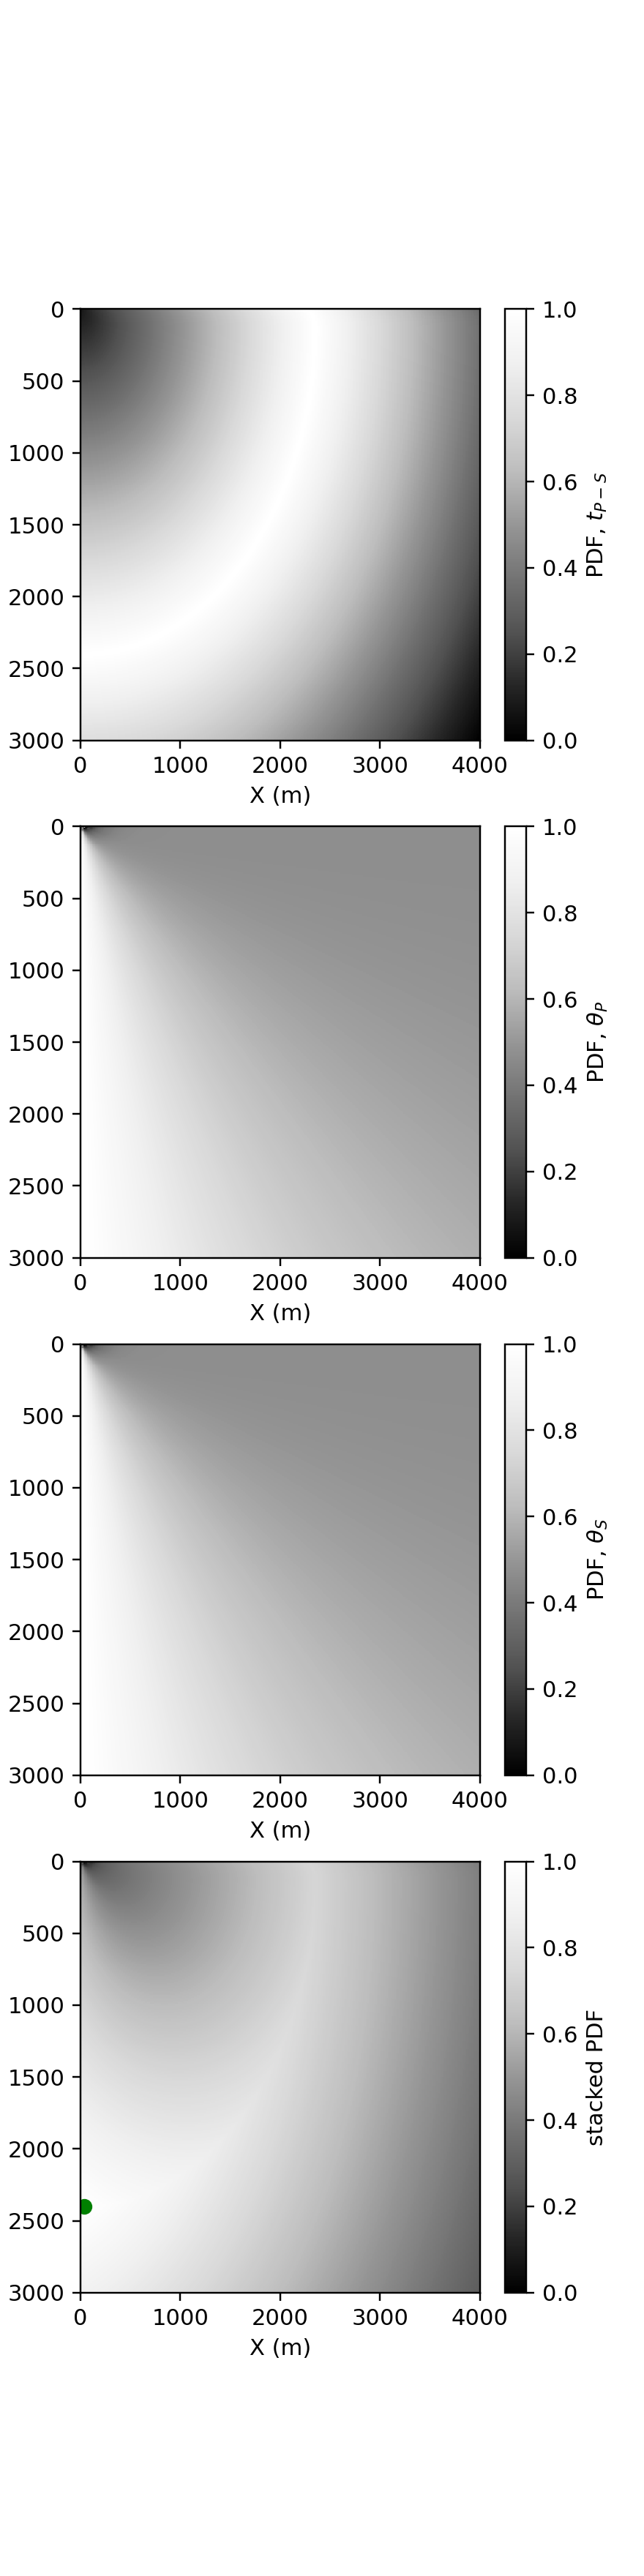

In [21]:
# Locate events:
receiver_vp = 2000 #3900
receiver_vs = 1000 #2000
array_latlon = [np.mean(stations_df['Latitude']), np.mean(stations_df['Longitude'])]
events_df = SeisSeeker.processing.location.locate_events_from_P_and_S_array_arrivals(events_df, LUTs_dict, array_latlon, receiver_vp, receiver_vs, verbosity=2)


In [22]:
# And plot stacked data for an event:
st_out_fname = "example_stacked_arrival.m"
composite_st_out_fname = st_out_fname.split('.')[0] + "_composite.m"
arrival_time = obspy.UTCDateTime(events_df['t1'].values[0])
bazis_1_2 = [events_df['bazi1'].values[0], events_df['bazi2'].values[0]]
slows_1_2 = [events_df['slow1'].values[0], events_df['slow2'].values[0]]
detect_obj.get_composite_array_st_from_bazi_slowness(arrival_time, bazis_1_2, slows_1_2, t_before_s=10, t_after_s=10, st_out_fname=st_out_fname)



/Users/eart0504/opt/anaconda3/lib/python3.7/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


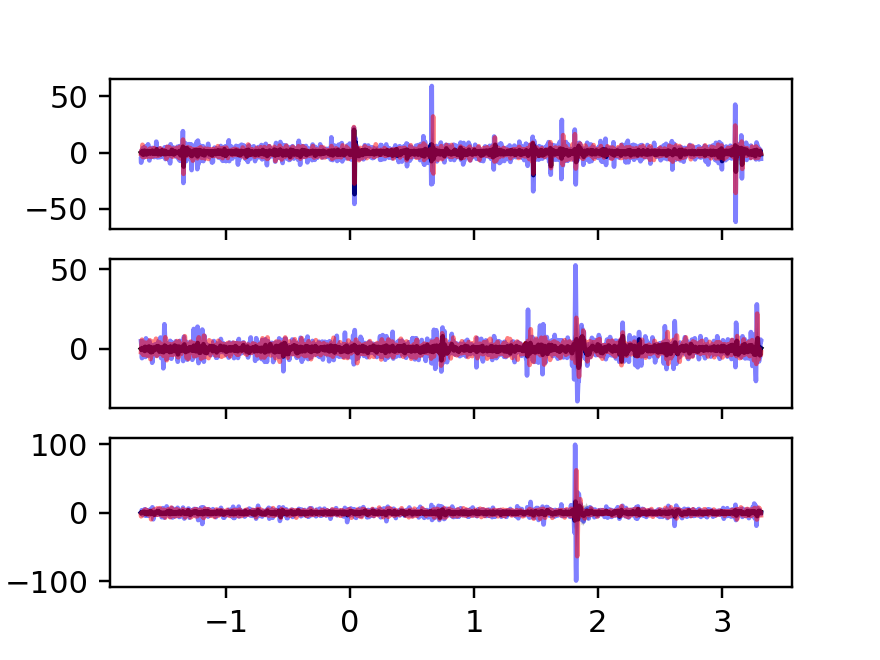

In [24]:
# And plot data:
# Load composite/stacked data:
composite_st = obspy.read(composite_st_out_fname)
composite_st.filter('bandpass', freqmin=1., freqmax=250.)
# Load unstacked data for comparison:
st_single_stations = obspy.read(st_out_fname)
fig, ax = plt.subplots(nrows=3, sharex=True)
t = (composite_st[0].stats.starttime - arrival_time) + np.arange(len(composite_st[0].data)) / composite_st[0].stats.sampling_rate
# Plot Z:
ax[0].plot(t, composite_st.select(station="MEAN", channel="??Z")[0].data, c='k')
ax[0].fill_between(t, composite_st.select(station="MEAN", channel="??Z")[0].data-composite_st.select(station="STDEV", channel="??Z")[0].data, composite_st.select(station="MEAN", channel="??Z")[0].data+composite_st.select(station="STDEV", channel="??Z")[0].data, fc='k', alpha=0.25)
ax[0].plot(t, st_single_stations.select(station="A000", channel="??Z")[0].data, c='b', alpha=0.5)
ax[0].plot(t, st_single_stations.select(station="AS33", channel="??Z")[0].data, c='r', alpha=0.5)
# Plot N:
ax[1].plot(t, composite_st.select(station="MEAN", channel="??N")[0].data, c='k')
ax[1].fill_between(t, composite_st.select(station="MEAN", channel="??N")[0].data-composite_st.select(station="STDEV", channel="??N")[0].data, composite_st.select(station="MEAN", channel="??N")[0].data+composite_st.select(station="STDEV", channel="??N")[0].data, fc='k', alpha=0.25)
ax[1].plot(t, st_single_stations.select(station="A000", channel="??1")[0].data, c='b', alpha=0.5)
ax[1].plot(t, st_single_stations.select(station="AS33", channel="??1")[0].data, c='r', alpha=0.5)
# Plot E:
ax[2].plot(t, composite_st.select(station="MEAN", channel="??E")[0].data, c='k')
ax[2].fill_between(t, composite_st.select(station="MEAN", channel="??E")[0].data-composite_st.select(station="STDEV", channel="??E")[0].data, composite_st.select(station="MEAN", channel="??E")[0].data+composite_st.select(station="STDEV", channel="??E")[0].data, fc='k', alpha=0.25)
ax[2].plot(t, st_single_stations.select(station="A000", channel="??2")[0].data, c='b', alpha=0.5)
ax[2].plot(t, st_single_stations.select(station="AS33", channel="??2")[0].data, c='r', alpha=0.5)
plt.show()


## 6. Test uncertainties:

Note: <mad_window_length_s> not yet implemented.
(Weighted horizontal slowness and back-azi using power)
Pre-processing time-series
Performing phase association
0 / 7
Writing events
Calculating uncertainty for event 1 / 2
Performing run for 378 windows
4.768099069595337


<IPython.core.display.Javascript object>


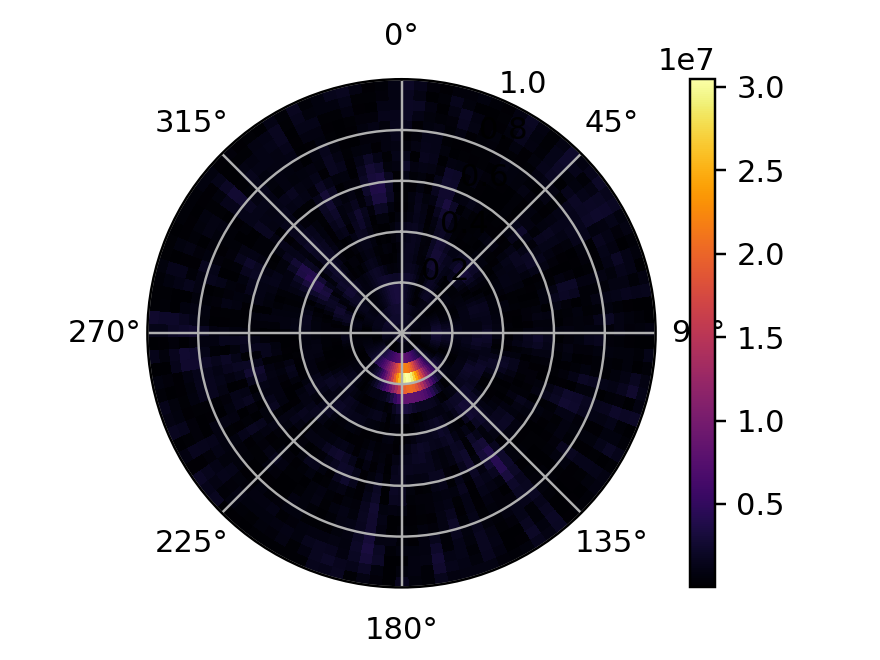

/Users/eart0504/Documents/python/github_repositories/SeisSeeker/SeisSeeker/processing/detection.py:968: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(th, r, Psum_opt, cmap='inferno')


Performing run for 325 windows
4.035317659378052
Performing run for 325 windows
4.035475254058838


<IPython.core.display.Javascript object>


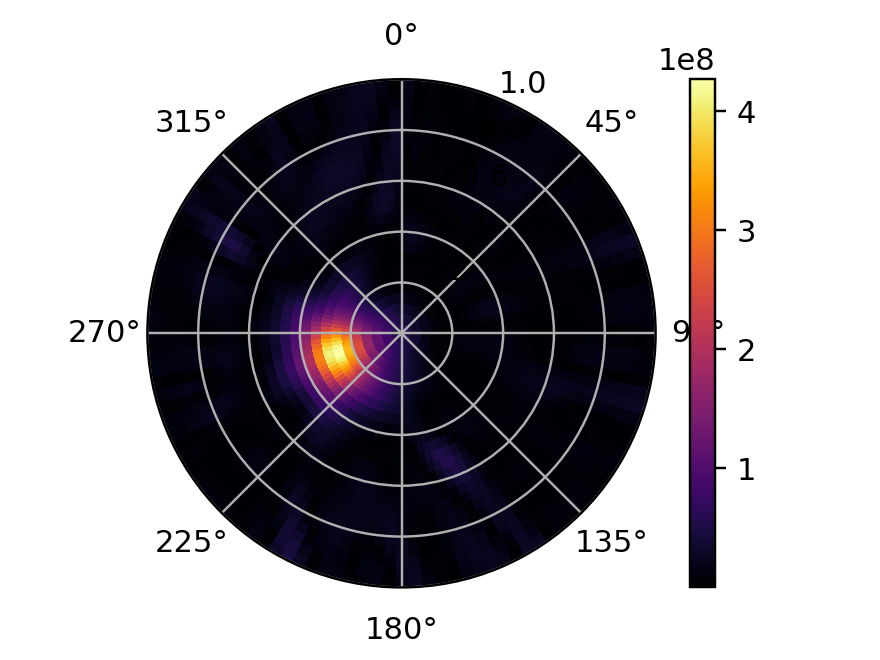

/Users/eart0504/Documents/python/github_repositories/SeisSeeker/SeisSeeker/processing/detection.py:1053: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(th, r, Psum_opt, cmap='inferno')


Performing run for 427 windows
5.368950605392456


<IPython.core.display.Javascript object>


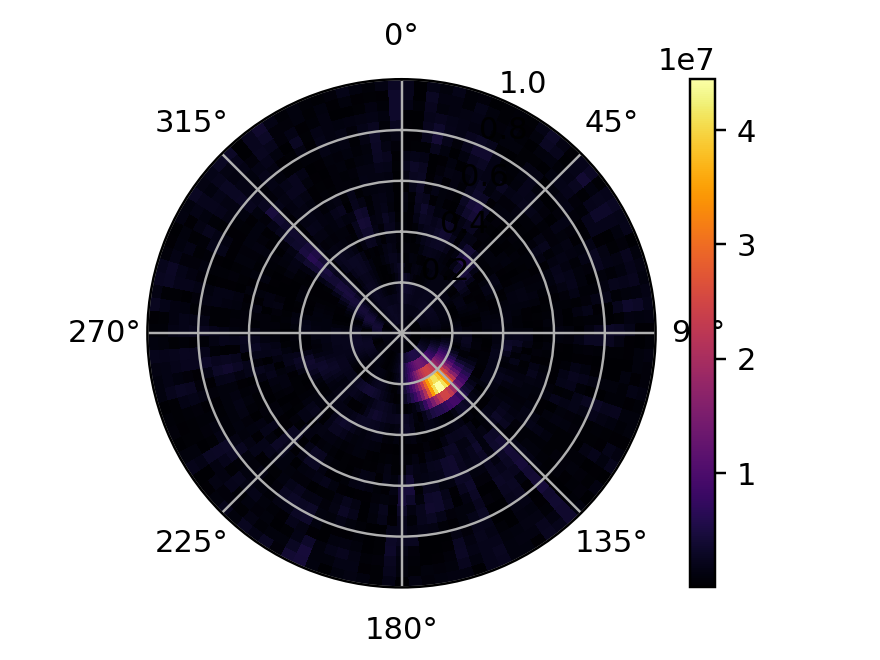

Performing run for 367 windows
4.495600700378418
Performing run for 367 windows
4.464853763580322


<IPython.core.display.Javascript object>


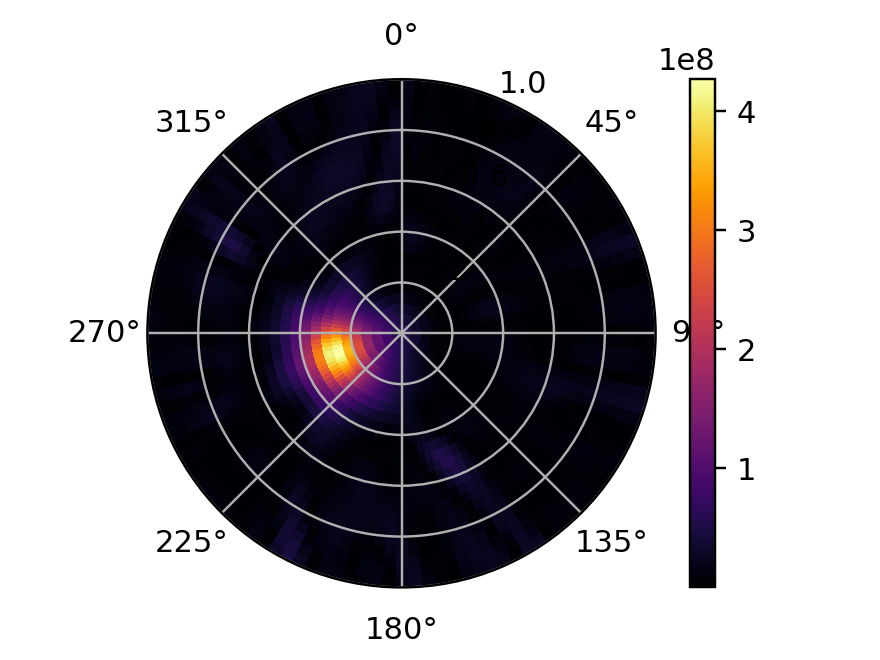

Event phase associations:
   bazi1       bazi2          pow1          pow2  slow1     slow2  \
0  171.0  159.000000  3.045238e+07  1.245514e+07   0.16  0.352379   
1  258.0  248.199685  5.618505e+06  3.346068e+08   0.12  0.240000   

                            t1                           t2  t1_err  t2_err  \
0  2020-01-01T01:30:47.685000Z  2020-01-01T01:30:49.845000Z    0.04    0.05   
1  2020-01-01T01:30:48.825000Z  2020-01-01T01:30:49.425000Z    0.03    0.09   

   slow1_err  slow2_err  bazi1_err  bazi2_err  
0   0.076923   0.115385       21.0       27.0  
1   0.076923   0.115385       15.0       27.0  


<IPython.core.display.Javascript object>


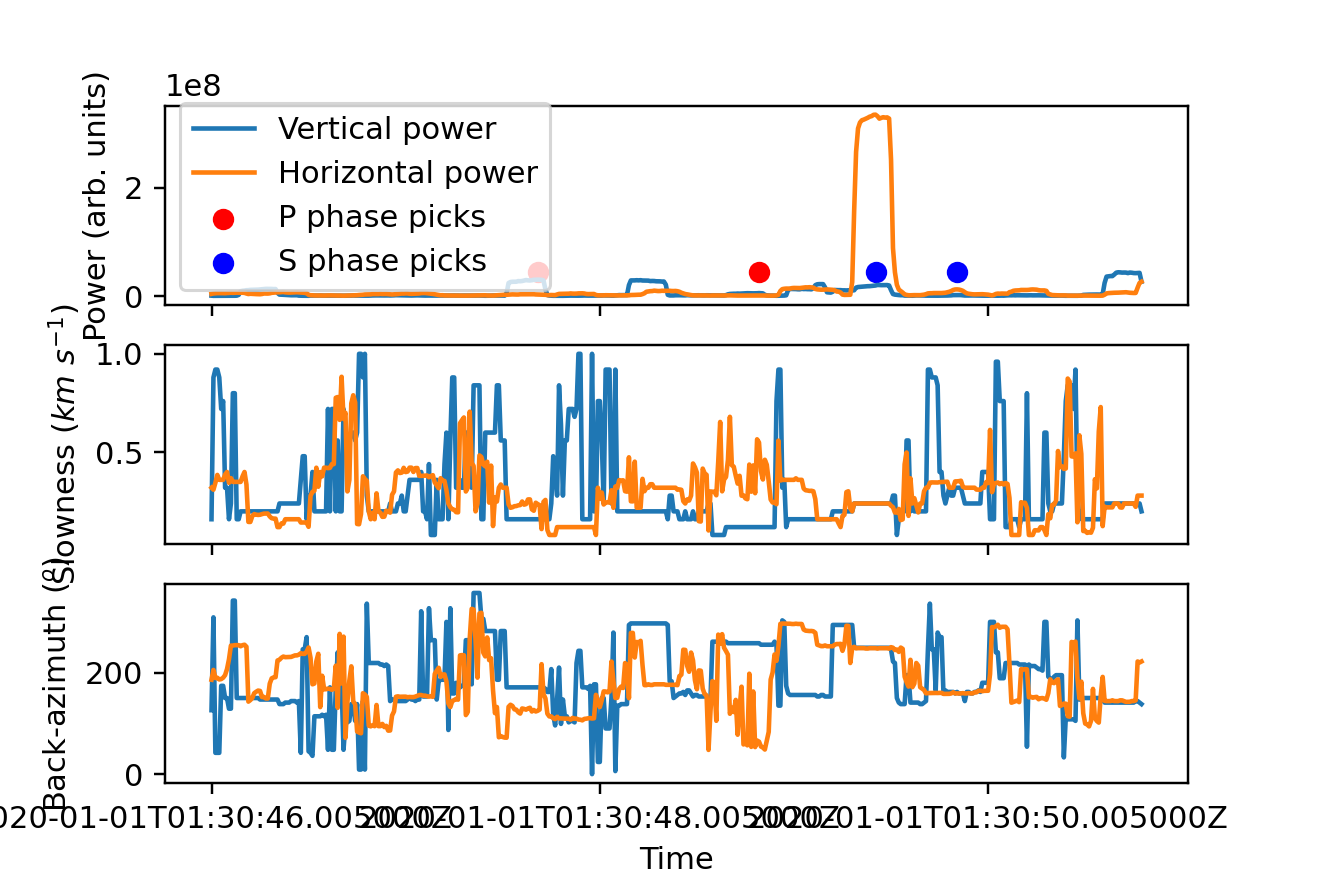

In [25]:
# Specify event detection parameters:
# --------- The following are specified previously ---------
# detect_obj.mad_window_length_s = 3600
# detect_obj.mad_multiplier = 15 #8
# detect_obj.min_event_sep_s = 0.25 #0.2 #0.2
# detect_obj.bazi_tol = 10 #45 #10.
# detect_obj.max_phase_sep_s = 4.0 #2.5
# detect_obj.filt_phase_assoc_by_max_power = True
# --------- The above are specified previously ---------
detect_obj.calc_uncertainties = True

events_df = detect_obj.detect_events(verbosity=2)